In [258]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

Reading data set from csv file and printing the first five rows to see what the dataset looks like

In [259]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Simple loop to see the number of positive/negative/neutral tweets for each airline.  This was used to decide which subset to cluster.  

In [260]:
for i in df['airline'].unique():
    print(i)
    print(df[df["airline"] == i].airline_sentiment.value_counts())
    print('\n')

Virgin America
negative    181
neutral     171
positive    152
Name: airline_sentiment, dtype: int64


United
negative    2633
neutral      697
positive     492
Name: airline_sentiment, dtype: int64


Southwest
negative    1186
neutral      664
positive     570
Name: airline_sentiment, dtype: int64


Delta
negative    955
neutral     723
positive    544
Name: airline_sentiment, dtype: int64


US Airways
negative    2263
neutral      381
positive     269
Name: airline_sentiment, dtype: int64


American
negative    1960
neutral      463
positive     336
Name: airline_sentiment, dtype: int64




Based on the output above we create a new dataframe for Southwest only.  The data seems to have an issue because tweets classified as Delta are addressing JetBlue.  For that reason we chose not to use the Delta subset.  Virgin America has a good distribution, but also has a very limited number of tweets.  For these reasons we chose Southwest as this subset has the least skewed distribution of positive/negative/neutral tweets (after Virgin America and Delta/JetBlue) while still having a resonable number of tweets.  Tweets were also re-indexed starting at 0 which is important so that they can be identified later when we print a tweet from each cluster.

In [261]:
single_airline = pd.DataFrame(df[df['airline'] == 'Southwest'])
single_airline.reset_index(drop=True, inplace=True)
single_airline.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570309156290367488,negative,1.0000,longlines,0.6624,Southwest,NaN,thisradlove,NaN,0,@SouthwestAir still waiting. Just hit one hour.,NaN,2015-02-24 11:47:53 -0800,Today I'm in: Maryland,Atlantic Time (Canada)
1,570309145276125185,negative,0.6361,Cancelled Flight,0.6361,Southwest,NaN,tomcblock,NaN,0,@SouthwestAir although I'm not happy you Cance...,NaN,2015-02-24 11:47:50 -0800,"ÜT: 38.965477,-77.428287",Eastern Time (US & Canada)
2,570307615189835777,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,cindyjwhitaker,NaN,0,@SouthwestAir Hello - been on hold for extreme...,NaN,2015-02-24 11:41:45 -0800,NaN,Central Time (US & Canada)
3,570306086475075585,neutral,0.6443,NaN,NaN,Southwest,NaN,liveseasoned,NaN,0,@SouthwestAir I'm teaching new #travelers how ...,NaN,2015-02-24 11:35:41 -0800,NaN,NaN
4,570305647759265793,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,cindyjwhitaker,NaN,0,@SouthwestAir Very frustrated for the loooooon...,NaN,2015-02-24 11:33:56 -0800,NaN,Central Time (US & Canada)


Here we check for missing data.  We are only really concerned with "text" for clusting, but we can see there are no null values.

In [262]:
single_airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      2420 non-null   int64  
 1   airline_sentiment             2420 non-null   object 
 2   airline_sentiment_confidence  2420 non-null   float64
 3   negativereason                1186 non-null   object 
 4   negativereason_confidence     1445 non-null   float64
 5   airline                       2420 non-null   object 
 6   airline_sentiment_gold        8 non-null      object 
 7   name                          2420 non-null   object 
 8   negativereason_gold           5 non-null      object 
 9   retweet_count                 2420 non-null   int64  
 10  text                          2420 non-null   object 
 11  tweet_coord                   160 non-null    object 
 12  tweet_created                 2420 non-null   object 
 13  twe

Here we are just doing a check to see that we have the correct subset before proceeding.

In [263]:
single_airline['text']

0         @SouthwestAir still waiting. Just hit one hour.
1       @SouthwestAir although I'm not happy you Cance...
2       @SouthwestAir Hello - been on hold for extreme...
3       @SouthwestAir I'm teaching new #travelers how ...
4       @SouthwestAir Very frustrated for the loooooon...
                              ...                        
2415    @SouthwestAir won't answer their phones #Horri...
2416    @SouthwestAir We have been stuck in SJU for se...
2417               @SouthwestAir nice work on the update!
2418    @SouthwestAir you guys there? Are we on hour 2...
2419    @SouthwestAir its cool that my bags take a bit...
Name: text, Length: 2420, dtype: object

Here we are creating a copy of our data subset and naming it X for simplicity.  It is imporant to use a copy as this keeps the orignal data intact so that we can reference the original tweet later when we show representative tweets for each cluster.

In [264]:
X = pd.Series.copy(single_airline.text)

It is clear the data still needs to be cleaned. We opted to do this manually as it was still fairly simple and it can be hard to speak to exactly what is happening when utilizing the tools available for data cleaning. The code below iterates through each tweet in the data set.
First we use regex to remove retweets, http links, bitly links, and emojis.  These items need to be removed as some are completely unique (links), and retweets could generate duplicate data when stripped down to text.  Emojis were removed as it can be hard to understand intention. Digits and words of length less than 3 were also removed.

This resource was used to aid in removing emojis: 
https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

Next, the string is split into individual words, then all punctuation and special characters are removed. Following that, all characters are converted to lowercase. Finally, the words are joined back into a string.

We knew what needed to be done here, but the following resource was used to help figure out how: https://machinelearningmastery.com/clean-text-machine-learning-python/

In [265]:
table = str.maketrans('', '', string.punctuation)

#remove emojis
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

for i, value in X.items():
    value = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', value)  # remove re-tweet
    value = re.sub("@[A-Za-z0-9_]+","", value)
    value = re.sub(r'http\S+', '', value)   # remove http links
    value = re.sub(r'bit.ly/\S+', '', value)  # remove bitly links
    value=re.sub('[^a-zA-Z]',' ',value) #remove any character that IS NOT a-z OR A-Z
    value = emoji_pattern.sub(r'', value)
    value = value.split()
    value =  ["" if t.isdigit() else t for t in value] #remove digits
    value = [w.translate(table) for w in value]
    value = [w.lower() for w in value]
    X[i] = ' '.join(word for word in value if len(word) > 2) #keep words of length greater than 2

Tfidf_vectorizer combines the count vectorizer and tfidf steps for simplicity. We set max features to 1000 so only the top 1000 most frequest words are used and we removed stop words.  After that we fit and transform our tfidf_vectorizer with the tweet data and transfrom the data into its tfidf representaion.  We used this in class and were already familiar with what this does, but it essentially assigns a numerical value to each word in the tweet as long as that word is one of the top 1000 most frequent words.  If it is not, the word will be assigned a weight of 0.  Values are based on how significant the word is which is determined by frequency.

Here we just used the sklean documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [266]:
tfidf_vectorizer = TfidfVectorizer(max_features=200, stop_words = 'english')
tweet_matrix = tfidf_vectorizer.fit_transform(X)

Print the cleaned tweets to see if they have been cleaned properly.  This isn't diffcult, but we leaned on the following resource for many of the following steps:

https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

This is a developer resource directly from twitter.

In [267]:
for i, value in enumerate(X):
    print(i,': ', value.replace('\n',' '))

0 :  still waiting just hit one hour
1 :  although not happy you cancelled flighted flight home tomorrow phx atl then dca happy how easy was rebook
2 :  hello been hold for extremely long time have confirmation amp can get boarding pass have tried numerous times
3 :  teaching new travelers how research budget amp save for trip today
4 :  very frustrated for the loooooong wait time speak live person cannot get boarding pass for flight tomorrow
5 :  still update text amp still response email feel like losing customer service care
6 :  your agents were the ones who were rude and unhelpful and prompted initial tweet this easy fix
7 :  wife had been group prev flight but got bumped for some reason alone with two kids least put her group
8 :  flight was delayed hrs months pregnant amp supposed caring for mom whose surgery now very upset
9 :  thank you much completely made things right
10 :  love them always get the best deals
11 :  can you follow can send you the info
12 :  been hold min far

Print the matrix representation of first 15 tweets.  While we knew intuitively that this can be done, we used Twitter's developer resource page to see how to print this representation:

https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

We really just wanted to see that everything is working to this point. This matrix is very sparse, but we can see above that the tweet at index 7 contains the word "wife".  In the matrix representation for this tweet, again, index 7, we can see "wife" has a weight of 0.769396.  This is an indication we are on the right track.

In [268]:
pd.DataFrame(tweet_matrix[:15].todense(), columns=[x for x in tfidf_vectorizer.get_feature_names()])

,able,account,add,agent,air,airline,airlines,airport,amazing,amp,...,want,way,weather,wife,wifi,won,work,working,worst,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282154,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457258,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.330530,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.769396,0.0,0.0,0.000000,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497540,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


Here we create an elbow graph to determine how many clusters to use for our data set.  This is something we talked about in class, so we knew to use this, but the following resouce was used to help us determine how to implement this in python:

https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

We just iterate from 1 to 8 clusters fitting the model with each value from number_clusters and score the results with inertia.  Inertia is the sum of squared distances of samples to their nearest cluster.  Here we are looking for the bend in towards the origin.  In some runs there have been multiple bends so we had to pick.  Additionally this has varied from run.

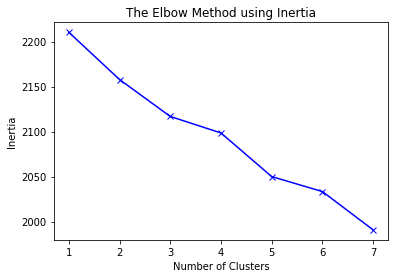

In [269]:
inertias = []
mapping = {}
number_clusters = range(1, 8)  # Range of possible clusters that can be generated

for k in number_clusters:
    kmeans = KMeans(n_clusters=k, max_iter = 600).fit(tweet_matrix)
    inertias.append(kmeans.inertia_)
    mapping[k] = kmeans.inertia_
    
plt.plot(number_clusters, inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Here we define and fit model with the ideal number of clusters based on the elbow graph above.

In [270]:
num_clusters = 6

kmeans = KMeans(n_clusters=num_clusters, max_iter=600)
kmeans.fit_predict(tweet_matrix)

array([5, 4, 0, ..., 0, 0, 0])

Here we are showing the top 10 words from each cluster. when we cluster the tweet_matrix vectors, each "feature" of the centroid represents the relevance of that word to it

https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster

In [271]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    print("Cluster %d:" % i)
    
    for j in sorted_centroids[i, :10]:
        print(' %s' % terms[j])
        
            
    print()

Cluster 0:
 destinationdragons
 flights
 help
 fly
 love
 hold
 southwest
 flying
 time
 amp

Cluster 1:
 thank
 service
 customer
 great
 hold
 response
 help
 got
 airline
 worst

Cluster 2:
 flight
 late
 delayed
 time
 tomorrow
 help
 book
 need
 hours
 hour

Cluster 3:
 thanks
 flight
 response
 got
 guys
 tomorrow
 great
 good
 sent
 southwest

Cluster 4:
 cancelled
 flightled
 flight
 flighted
 flights
 hold
 help
 today
 need
 weather

Cluster 5:
 just
 sent
 got
 flight
 time
 thanks
 did
 day
 best
 like



Here we create another graph to show the number of tweets in each cluster.  In each run, one cluster usually has substantailly more tweets than the others.  We believe this is due the input data being skewed with many more negative tweets than positive/neutral tweets.  The code for this was borrowed from Twitter's developer resource:

https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

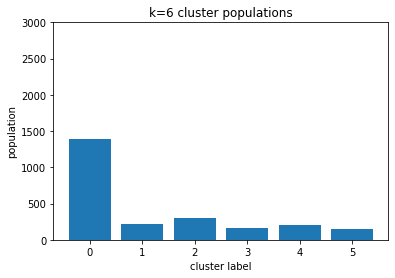

In [272]:
plt.bar(range(len(set(kmeans.labels_))), np.bincount(kmeans.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('k={} cluster populations'.format(num_clusters));

plt.ylim(0,3000);

Finally we print a representative tweet from each cluster.  The turned out to be fairly simple, but we again relied on Twitter's developer resource to see how this is done:

https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

In [273]:
for i in range(num_clusters): 
    print("Cluster %d representative tweet:\n" % i)
    tweet_idx = np.where(kmeans.labels_ == i)[0].item(0)
    print(single_airline.text[tweet_idx])
    print()

Cluster 0 representative tweet:

@SouthwestAir Hello - been on hold for extremely long time. Have confirmation # &amp; can't get boarding pass. Have tried numerous times!!

Cluster 1 representative tweet:

@SouthwestAir still no update text #2053 &amp; still no response to email fr1/5/2015 SR #256746438028. Feel like yr losing customer service/care

Cluster 2 representative tweet:

@SouthwestAir Very frustrated for the loooooong wait time to speak to a live person!!! Cannot get boarding pass for flight tomorrow!!

Cluster 3 representative tweet:

@SouthwestAir  thanks Southwest for saving our trip. my sweetheart isn't going to miss seeing #AltonBrownLive thanks to y'all! #SOhappy

Cluster 4 representative tweet:

@SouthwestAir although I'm not happy you Cancelled Flighted my flight home tomorrow (phx to atl then dca) I am happy on how easy it was to rebook

Cluster 5 representative tweet:

@SouthwestAir still waiting. Just hit one hour.

